In [30]:
pip install pystokes

## Example 2 : sedimentation of polymers

In [31]:
 import numpy as np
import pystokes
from tqdm import tqdm

import sys

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from IPython.display import Video
import os
from matplotlib.animation import FuncAnimation

import io
from PIL import Image

## Velocity of $N$ sedimenting spheres

$$\mathbf{V}_1 =\mu^T_{11}\cdot\mathbf{F}_1+\boldsymbol \mu^{TT}_{12}\cdot\mathbf{F}_2,$$

$$\mathbf{V}_2 =\mu^T_{22}\cdot\mathbf{F}_2+\boldsymbol \mu^{TT}_{21}\cdot\mathbf{F}_1,$$


Here, we have defined

$$\boldsymbol \mu^{TT}_{12} = \boldsymbol {G} (\boldsymbol{R}_1-\boldsymbol{R}_2). $$

Here $\boldsymbol R_i$ is the location of the $i$th particle and $\boldsymbol {G}$ is a tensor of rank 2. It is given as:

$$
G_{\alpha\beta}=\frac{1}{8\pi\eta}\left(\frac{\delta_{\alpha\beta}}{r_{12}}
+\frac{(r_{12})_{\alpha}(r_{12})_{\beta}}{r^3_{12}}\right)
$$

It is useful to note that

$$
\boldsymbol\mu_{11}^{TT} =\mu_0^T \, \mathbf I=\frac{1}{6\pi\eta b}\mathbf I
$$

Here $\mathbf I$ is the identity tensor. We will assume spheres of equal sizes. Thus,

$$
\boldsymbol\mu_{ii}^{TT} =\mu_0^T \, \mathbf I=\frac{1}{6\pi\eta b}\mathbf I
$$

## Velocity of $N$ sedimenting spheres

$$\mathbf{V}_i =\sum_j \boldsymbol \mu^{TT}_{ij}\cdot\mathbf{F}_j,$$

The above is the quantity which PyStokes compute when you call `mobilityTT(v, r, F)`.

(-1.0, 1.0)

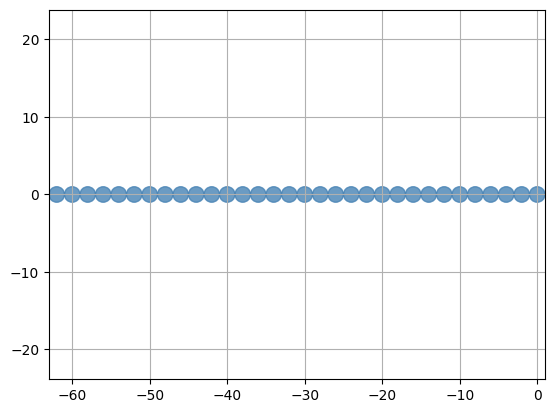

In [32]:
N=32 ## number of particles
b=1 ## radius of the particle

position0=np.zeros(3*N);
position0[0:N]=-np.arange(0,N)*2*b

fig = plt.figure(); ax = plt.gca();  plt.grid(); plt.axis('equal');
x, y = position0[0:N], position0[N:2*N]

for j in range(N):
    ax.add_patch(patches.Circle((x[j],y[j]),b,color='steelblue',alpha=0.8))

plt.xlim(np.min(x)-b, np.max(x)+b)
plt.ylim(np.min(y)-b, np.max(y)+b)

In [33]:
 ## Using pystokes

# particle radius, self-propulsion speed, number and fluid viscosity
b, vs, eta = 1.0, 1, 0.1

rbm   = pystokes.unbounded.Rbm(radius=b, particles=N, viscosity=eta)
force = pystokes.forceFields.Forces(particles=N)

In [34]:
 # parameters
mu=1/(6*np.pi*eta*b)
dt=0.003
bondLength=2*b
springModulus=100
Nf=1

bendModulus, lje = 50, 0
twistModulus=0


In [35]:
 def rhs(dX, position):
    F = np.zeros(3*N)
    v = np.zeros(3*N)

    force.multipolymers(Nf, F, position, bondLength, springModulus,  bendModulus, twistModulus)
    for i in range(N):
        F[i+2*N] += Fg
    rbm.mobilityTT(v, position, F)

    for i in range(N):
        dX[i]     = v[i]*dt
        dX[i+N]   = v[i+N]*dt
        dX[i+2*N] = v[i+2*N]*dt
    return

In [36]:
 Lf=N*2*b
paramB=100
Fg = -paramB*bendModulus/(Lf**3)


##----------------------
### integrator
###----------------------
totTime=300
Nt=int(totTime/dt)
X1 = np.zeros((Nt, 3*N));
dX1 = np.zeros(3*N)


position1=position0 # specify initial condition

for i in tqdm(range(Nt)):

    ## saveData
    X1[i,0:3*N]=position1;

    rhs(dX1, position1)

    ## positional update is \dot r = V
    position1 += dX1[0:3*N]

100%|██████████| 100000/100000 [00:20<00:00, 4884.11it/s]


Text(0, 0.5, 'z/b')

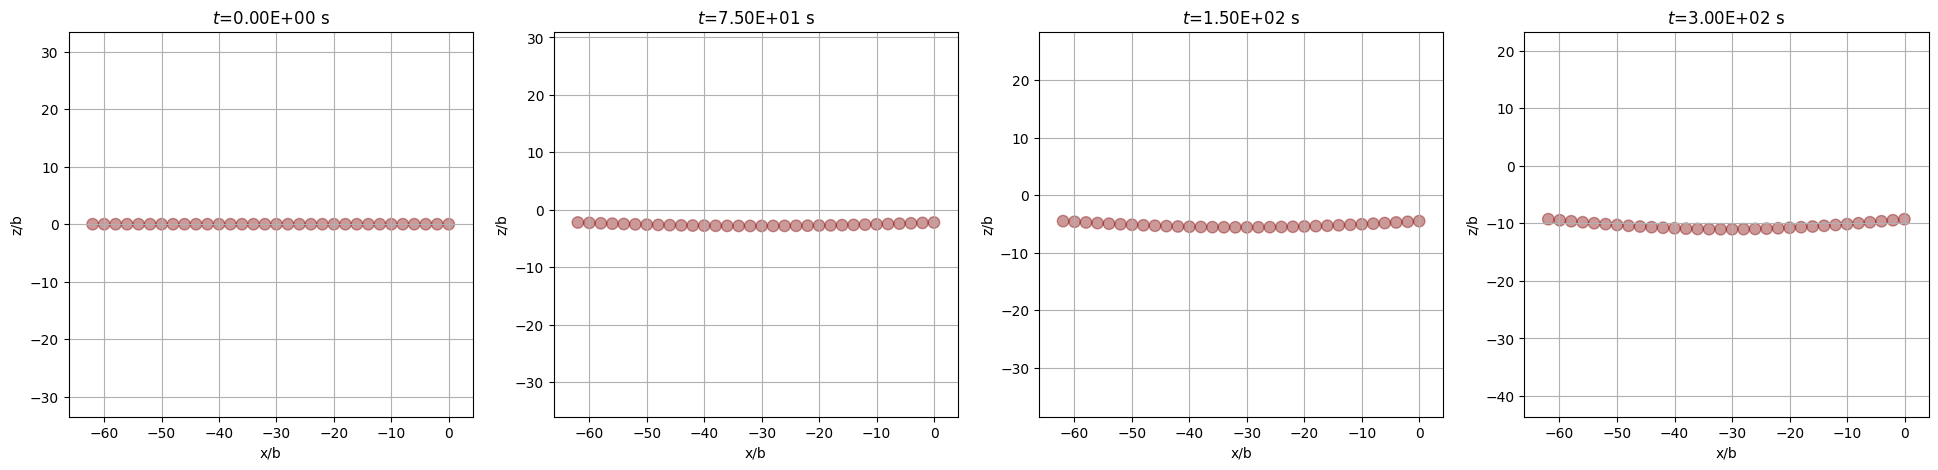

In [37]:
fig=plt.figure(figsize=(24,5))


ax = fig.add_subplot(1, 4, 1 )
fTp=0
x, y, z = X1[fTp, 0:N],  X1[fTp, N:2*N],  X1[fTp, 2*N:3*N]


for j in range(N):
    ax.add_patch(patches.Circle((x[j],z[j]),b/b,color='maroon',alpha=0.4))
    plt.xlim(np.min(x)-2*b, np.max(x)+2*b)
plt.ylim(np.min(z)-2*b, np.max(z)+2*b)
plt.grid(); plt.axis('equal');
plt.title('$t$=%1.2E s'%((fTp*dt)))
plt.xlabel('x/b')
plt.ylabel('z/b')


ax = fig.add_subplot(1, 4, 2 )

fTp=int(Nt/4)
x, y, z = X1[fTp, 0:N],  X1[fTp, N:2*N],  X1[fTp, 2*N:3*N]
# ax.scatter(x, y, z )

for j in range(N):
    ax.add_patch(patches.Circle((x[j],z[j]),b/b,color='maroon',alpha=0.4))
plt.xlim(np.min(x)-2*b, np.max(x)+2*b)
plt.ylim(np.min(z)-2*b, np.max(z)+2*b)
plt.grid(); plt.axis('equal');
plt.title('$t$=%1.2E s'%((fTp*dt)))
plt.xlabel('x/b')
plt.ylabel('z/b')


ax = fig.add_subplot(1, 4, 3 )

fTp=int(Nt/2)
x, y, z = X1[fTp, 0:N],  X1[fTp, N:2*N],  X1[fTp, 2*N:3*N]
# ax.scatter(x, y, z )
for j in range(N):
    ax.add_patch(patches.Circle((x[j],z[j]),b/b,color='maroon',alpha=.4))
plt.xlim(np.min(x)-2*b, np.max(x)+2*b)
plt.ylim(np.min(z)-2*b, np.max(z)+2*b)
plt.grid(); plt.axis('equal');
plt.title('$t$=%1.2E s'%((fTp*dt)))
plt.xlabel('x/b')
plt.ylabel('z/b')


ax = fig.add_subplot(1, 4, 4 )

fTp=Nt-1
x, y, z = X1[fTp, 0:N],  X1[fTp, N:2*N],  X1[fTp, 2*N:3*N]
# ax.scatter(x, y, z )
for j in range(N):
    ax.add_patch(patches.Circle((x[j],z[j]),b/b,color='maroon',alpha=.4))


plt.xlim(np.min(x)-2*b, np.max(x)+2*b)
plt.ylim(np.min(z)-2*b, np.max(z)+2*b)
plt.grid(); plt.axis('equal');
plt.title('$t$=%1.2E s'%((fTp*dt)))
plt.xlabel('x/b')
plt.ylabel('z/b')